# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 28.01.2022

Мягкий дедлайн: 23:59MSK 14.02.2022

Жесткий дедлайн: 23:59MSK 17.02.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [23]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

In [1]:
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression 
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import time
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [25]:
np.random.seed(2001)

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:    
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = len(X.T)
        rand = np.random.randint(low=0, high = len(X), size = 2*10**6).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X[rand][:,0] - X[rand][:,1])**2,axis = 1)))
        self.W  = np.random.normal(0, 1/sigma, size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size = (1,self.n_features))
        x_res = np.cos(np.dot(X, self.W) + self.b)
        if self.classifier == 'logreg':
            self.cl = LogisticRegression(max_iter = 10**4)
            self.cl.fit(x_res, y)
        else:
            self.cl = SVC(kernel = 'linear', probability=True)
            self.cl.fit(x_res,y)
        #raise NotImplementedError
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = np.cos(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict_proba(X_test)
    
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = np.cos(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict(X_test)

In [78]:
%%time
rff = RFFPipeline(n_features=1000)
rff.fit(x_train, y_train)

Wall time: 1h 1min 6s


RFFPipeline()

In [79]:
print('accuracy: ', accuracy_score(y_test, rff.predict(x_test)))
print('probability: ', rff.predict_proba(x_test))

accuracy:  0.8801
probability:  [[3.88331052e-07 1.53883257e-10 8.21889958e-08 ... 2.74574082e-02
  2.72220336e-04 9.44617170e-01]
 [5.38155710e-02 4.13470242e-10 9.45454170e-01 ... 1.61166186e-22
  1.79453365e-09 4.51521959e-15]
 [2.68495871e-08 9.99999914e-01 5.80888660e-10 ... 3.28252584e-18
  2.35192698e-10 1.02405143e-12]
 ...
 [3.91716887e-04 2.73239194e-09 1.09373335e-04 ... 4.17711570e-08
  9.98151757e-01 7.95875421e-11]
 [2.17218477e-06 9.99841755e-01 1.21741766e-07 ... 7.53976249e-11
  4.69327801e-08 1.40674570e-07]
 [3.84505878e-06 4.52596904e-07 8.34511682e-05 ... 4.70787703e-03
  1.30428732e-03 1.72283453e-05]]


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [80]:
time_rff_fit = []
time_rbf_fit = []
time_rff_predict = []
time_rbf_predict = []
accuracy_rff = []
accuracy_rbf = []
observations = []
for i in enumerate([10000,12000,15000,20000,30000,40000]):
    start_time = time.time()
    rff = RFFPipeline(classifier = 'svm')
    rff.fit(x_train[0:i[1]], y_train[0:i[1]])
    time_rff_fit.append((time.time() - start_time)/60)
    
    start_time = time.time()
    pred_rff = rff.predict(x_test)
    time_rff_predict.append((time.time() - start_time)/60)
    
    accuracy_rff.append(accuracy_score(y_test, pred_rff))
    
    start_time = time.time()
    svm_rbf = SVC(kernel = 'rbf')
    svm_rbf.fit(x_train[0:i[1]], y_train[0:i[1]])
    time_rbf_fit.append((time.time() - start_time)/60)
    
    start_time = time.time()                  
    pred_rbf = svm_rbf.predict(x_test)
    time_rbf_predict.append((time.time() - start_time)/60)
    
    accuracy_rbf.append((accuracy_score(y_test, pred_rbf)))
    
    observations.append(i[1])

In [81]:
time_lin_fit = []
time_lin_predict = []
accuracy_lin = []
for i in tqdm(enumerate([10000,12000,15000,20000,30000,40000])):
    start_time = time.time()
    svm_lin = LinearSVC(max_iter=10**5)
    svm_lin.fit(x_train[0:i[1]], y_train[0:i[1]])
    time_lin_fit.append((time.time() - start_time)/60)
    
    start_time = time.time()                  
    pred_lin = svm_lin.predict(x_test)
    time_lin_predict.append((time.time() - start_time)/60)
    
    accuracy_lin.append((accuracy_score(y_test, pred_lin)))

In [82]:
data = pd.DataFrame({'time_rff_fit':time_rff_fit,
                     'time_rbf_fit':time_rbf_fit,
                     'time_lin_fit':time_lin_fit,
                     'time_rff_predict':time_rff_predict,
                     'time_rbf_predict':time_rbf_predict,
                     'time_lin_predict': time_lin_predict,
                     'accuracy_rff':accuracy_rff,
                     'accuracy_rbf':accuracy_rbf,
                     'accuracy_lin':accuracy_lin,
                     'n_observations':observations})
data.to_csv('rff_lin_rbf_new')

In [86]:
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import GridSearchCV

In [86]:
pca = PCA(n_components = 50)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [87]:
%%time
param_grid = {
             'iterations':1000,
             'loss_function': 'MultiClass'}
cv_dataset = Pool(x_train[0:30000],
                  label=y_train[0:30000])
cv_data = cv(cv_dataset,
    params=param_grid,
    fold_count=3,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.3529394511
bestIteration = 999

Training on fold [1/3]

bestTest = 0.3546735296
bestIteration = 999

Training on fold [2/3]

bestTest = 0.3508364865
bestIteration = 999

Wall time: 4h 20min 52s


In [88]:
param_grid = {'learning_rate':0.9,
             'iterations':1000,
             'loss_function': 'MultiClass'}
cv_dataset = Pool(x_train[0:30000],
                  label=y_train[0:30000])
cv_data_1 = cv(cv_dataset,
    params=param_grid,
    fold_count=3,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.5033801739
bestIteration = 661

Training on fold [1/3]

bestTest = 0.5853343782
bestIteration = 479

Training on fold [2/3]

bestTest = 0.8107699281
bestIteration = 395



In [89]:
param_grid = {'learning_rate':0.5,
             'iterations':1000,
             'loss_function': 'MultiClass'}
cv_dataset = Pool(x_train[0:30000],
                  label=y_train[0:30000])
cv_data_2 = cv(cv_dataset,
    params=param_grid,
    fold_count=3,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.3579536743
bestIteration = 570

Training on fold [1/3]

bestTest = 0.371912309
bestIteration = 644

Training on fold [2/3]

bestTest = 0.3610597869
bestIteration = 675



In [90]:
param_grid = {'learning_rate':0.1,
             'iterations':1000,
             'loss_function': 'MultiClass'}
cv_dataset = Pool(x_train[0:30000],
                  label=y_train[0:30000])
cv_data_3 = cv(cv_dataset,
    params=param_grid,
    fold_count=3,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.3115848192
bestIteration = 999

Training on fold [1/3]

bestTest = 0.3117569182
bestIteration = 999

Training on fold [2/3]

bestTest = 0.3087193573
bestIteration = 999



In [92]:
time_boost_fit = []
time_boost_predict = []
accuracy_boost = []
for i in tqdm(enumerate([10000,12000,15000,20000,30000,40000])):
    start_time = time.time()
   
    time_boost_fit.append((time.time() - start_time)/60)
    
    start_time = time.time()
    cat = CatBoostClassifier(learning_rate=0.1, n_estimators = 1000,loss_function ='MultiClass')
    cat.fit(x_train[0:i[1]], y_train[0:i[1]])
    time_boost_fit.append((time.time() - start_time)/60)
    
    start_time = time.time()
    pred_boost = cat.predict(x_test)
    time_boost_predict.append((time.time() - start_time)/60)
    
    accuracy_boost.append(accuracy_score(y_test, pred_boost))

0:	learn: 1.9446482	total: 3.65s	remaining: 1h 42s
1:	learn: 1.7218755	total: 7.41s	remaining: 1h 1m 38s
2:	learn: 1.5637347	total: 11.3s	remaining: 1h 2m 52s
3:	learn: 1.4427537	total: 14.9s	remaining: 1h 2m
4:	learn: 1.3450846	total: 18.5s	remaining: 1h 1m 31s
5:	learn: 1.2629632	total: 22.2s	remaining: 1h 1m 10s
6:	learn: 1.1906311	total: 26.2s	remaining: 1h 1m 51s
7:	learn: 1.1254632	total: 29.8s	remaining: 1h 1m 36s
8:	learn: 1.0718960	total: 33.4s	remaining: 1h 1m 19s
9:	learn: 1.0201820	total: 37s	remaining: 1h 1m 5s
10:	learn: 0.9783034	total: 41s	remaining: 1h 1m 22s
11:	learn: 0.9395150	total: 44.7s	remaining: 1h 1m 21s
12:	learn: 0.9042834	total: 48.3s	remaining: 1h 1m 8s
13:	learn: 0.8721056	total: 52.3s	remaining: 1h 1m 26s
14:	learn: 0.8437724	total: 56.2s	remaining: 1h 1m 33s
15:	learn: 0.8167070	total: 1m	remaining: 1h 1m 36s
16:	learn: 0.7928638	total: 1m 3s	remaining: 1h 1m 21s
17:	learn: 0.7717291	total: 1m 7s	remaining: 1h 1m 9s
18:	learn: 0.7500709	total: 1m 10s	re

153:	learn: 0.3254446	total: 9m 13s	remaining: 50m 40s
154:	learn: 0.3240593	total: 9m 16s	remaining: 50m 36s
155:	learn: 0.3235632	total: 9m 20s	remaining: 50m 31s
156:	learn: 0.3223861	total: 9m 23s	remaining: 50m 26s
157:	learn: 0.3214185	total: 9m 27s	remaining: 50m 23s
158:	learn: 0.3208146	total: 9m 30s	remaining: 50m 19s
159:	learn: 0.3200457	total: 9m 34s	remaining: 50m 14s
160:	learn: 0.3198385	total: 9m 37s	remaining: 50m 9s
161:	learn: 0.3182284	total: 9m 40s	remaining: 50m 4s
162:	learn: 0.3174784	total: 9m 44s	remaining: 50m 2s
163:	learn: 0.3169415	total: 9m 47s	remaining: 49m 57s
164:	learn: 0.3169066	total: 9m 51s	remaining: 49m 52s
165:	learn: 0.3162975	total: 9m 54s	remaining: 49m 47s
166:	learn: 0.3155099	total: 9m 58s	remaining: 49m 42s
167:	learn: 0.3148785	total: 10m 1s	remaining: 49m 40s
168:	learn: 0.3143439	total: 10m 5s	remaining: 49m 35s
169:	learn: 0.3137550	total: 10m 8s	remaining: 49m 30s
170:	learn: 0.3133383	total: 10m 11s	remaining: 49m 25s
171:	learn: 

301:	learn: 0.2495354	total: 17m 31s	remaining: 40m 31s
302:	learn: 0.2491482	total: 17m 35s	remaining: 40m 27s
303:	learn: 0.2488812	total: 17m 39s	remaining: 40m 24s
304:	learn: 0.2481756	total: 17m 42s	remaining: 40m 21s
305:	learn: 0.2475700	total: 17m 46s	remaining: 40m 18s
306:	learn: 0.2471119	total: 17m 50s	remaining: 40m 15s
307:	learn: 0.2469497	total: 17m 53s	remaining: 40m 11s
308:	learn: 0.2468046	total: 17m 56s	remaining: 40m 8s
309:	learn: 0.2464039	total: 18m	remaining: 40m 5s
310:	learn: 0.2459928	total: 18m 4s	remaining: 40m 1s
311:	learn: 0.2455817	total: 18m 7s	remaining: 39m 57s
312:	learn: 0.2452275	total: 18m 10s	remaining: 39m 53s
313:	learn: 0.2447584	total: 18m 14s	remaining: 39m 50s
314:	learn: 0.2445127	total: 18m 17s	remaining: 39m 47s
315:	learn: 0.2442165	total: 18m 21s	remaining: 39m 43s
316:	learn: 0.2438077	total: 18m 24s	remaining: 39m 39s
317:	learn: 0.2437402	total: 18m 27s	remaining: 39m 35s
318:	learn: 0.2432682	total: 18m 31s	remaining: 39m 32s
3

449:	learn: 0.1998189	total: 25m 54s	remaining: 31m 40s
450:	learn: 0.1996531	total: 25m 58s	remaining: 31m 36s
451:	learn: 0.1991511	total: 26m 1s	remaining: 31m 33s
452:	learn: 0.1987345	total: 26m 4s	remaining: 31m 29s
453:	learn: 0.1982693	total: 26m 8s	remaining: 31m 25s
454:	learn: 0.1981768	total: 26m 11s	remaining: 31m 22s
455:	learn: 0.1978783	total: 26m 14s	remaining: 31m 18s
456:	learn: 0.1973638	total: 26m 18s	remaining: 31m 15s
457:	learn: 0.1972092	total: 26m 21s	remaining: 31m 11s
458:	learn: 0.1966549	total: 26m 24s	remaining: 31m 8s
459:	learn: 0.1964394	total: 26m 28s	remaining: 31m 4s
460:	learn: 0.1960648	total: 26m 31s	remaining: 31m 1s
461:	learn: 0.1955324	total: 26m 35s	remaining: 30m 57s
462:	learn: 0.1952393	total: 26m 38s	remaining: 30m 53s
463:	learn: 0.1949693	total: 26m 41s	remaining: 30m 50s
464:	learn: 0.1947815	total: 26m 45s	remaining: 30m 46s
465:	learn: 0.1946006	total: 26m 48s	remaining: 30m 43s
466:	learn: 0.1943995	total: 26m 51s	remaining: 30m 39

597:	learn: 0.1635366	total: 34m 27s	remaining: 23m 9s
598:	learn: 0.1633008	total: 34m 31s	remaining: 23m 6s
599:	learn: 0.1630536	total: 34m 34s	remaining: 23m 3s
600:	learn: 0.1629078	total: 34m 37s	remaining: 22m 59s
601:	learn: 0.1626841	total: 34m 41s	remaining: 22m 56s
602:	learn: 0.1619841	total: 34m 45s	remaining: 22m 52s
603:	learn: 0.1615168	total: 34m 48s	remaining: 22m 49s
604:	learn: 0.1613042	total: 34m 52s	remaining: 22m 45s
605:	learn: 0.1608102	total: 34m 55s	remaining: 22m 42s
606:	learn: 0.1605500	total: 34m 59s	remaining: 22m 39s
607:	learn: 0.1604583	total: 35m 3s	remaining: 22m 35s
608:	learn: 0.1601962	total: 35m 6s	remaining: 22m 32s
609:	learn: 0.1600757	total: 35m 9s	remaining: 22m 28s
610:	learn: 0.1598135	total: 35m 13s	remaining: 22m 25s
611:	learn: 0.1595208	total: 35m 17s	remaining: 22m 22s
612:	learn: 0.1594095	total: 35m 20s	remaining: 22m 18s
613:	learn: 0.1592125	total: 35m 24s	remaining: 22m 15s
614:	learn: 0.1588556	total: 35m 27s	remaining: 22m 11

745:	learn: 0.1362966	total: 43m 11s	remaining: 14m 42s
746:	learn: 0.1362336	total: 43m 15s	remaining: 14m 38s
747:	learn: 0.1361887	total: 43m 18s	remaining: 14m 35s
748:	learn: 0.1360981	total: 43m 22s	remaining: 14m 31s
749:	learn: 0.1360445	total: 43m 25s	remaining: 14m 28s
750:	learn: 0.1358410	total: 43m 28s	remaining: 14m 24s
751:	learn: 0.1357521	total: 43m 32s	remaining: 14m 21s
752:	learn: 0.1356305	total: 43m 36s	remaining: 14m 18s
753:	learn: 0.1353862	total: 43m 39s	remaining: 14m 14s
754:	learn: 0.1352393	total: 43m 42s	remaining: 14m 11s
755:	learn: 0.1350139	total: 43m 46s	remaining: 14m 7s
756:	learn: 0.1348361	total: 43m 50s	remaining: 14m 4s
757:	learn: 0.1346353	total: 43m 53s	remaining: 14m
758:	learn: 0.1345335	total: 43m 56s	remaining: 13m 57s
759:	learn: 0.1341802	total: 44m	remaining: 13m 53s
760:	learn: 0.1340876	total: 44m 4s	remaining: 13m 50s
761:	learn: 0.1340416	total: 44m 7s	remaining: 13m 46s
762:	learn: 0.1338435	total: 44m 10s	remaining: 13m 43s
763:

894:	learn: 0.1156657	total: 51m 56s	remaining: 6m 5s
895:	learn: 0.1155995	total: 51m 59s	remaining: 6m 2s
896:	learn: 0.1154722	total: 52m 3s	remaining: 5m 58s
897:	learn: 0.1152729	total: 52m 6s	remaining: 5m 55s
898:	learn: 0.1151609	total: 52m 10s	remaining: 5m 51s
899:	learn: 0.1150917	total: 52m 13s	remaining: 5m 48s
900:	learn: 0.1150634	total: 52m 17s	remaining: 5m 44s
901:	learn: 0.1150127	total: 52m 21s	remaining: 5m 41s
902:	learn: 0.1148926	total: 52m 24s	remaining: 5m 37s
903:	learn: 0.1148453	total: 52m 27s	remaining: 5m 34s
904:	learn: 0.1145436	total: 52m 31s	remaining: 5m 30s
905:	learn: 0.1143419	total: 52m 35s	remaining: 5m 27s
906:	learn: 0.1142310	total: 52m 38s	remaining: 5m 23s
907:	learn: 0.1141214	total: 52m 42s	remaining: 5m 20s
908:	learn: 0.1139925	total: 52m 45s	remaining: 5m 16s
909:	learn: 0.1138413	total: 52m 48s	remaining: 5m 13s
910:	learn: 0.1137611	total: 52m 52s	remaining: 5m 9s
911:	learn: 0.1135035	total: 52m 56s	remaining: 5m 6s
912:	learn: 0.11

45:	learn: 0.4956254	total: 2m 58s	remaining: 1h 1m 47s
46:	learn: 0.4914380	total: 3m 3s	remaining: 1h 1m 51s
47:	learn: 0.4878936	total: 3m 6s	remaining: 1h 1m 46s
48:	learn: 0.4829777	total: 3m 10s	remaining: 1h 1m 39s
49:	learn: 0.4794849	total: 3m 14s	remaining: 1h 1m 33s
50:	learn: 0.4762982	total: 3m 18s	remaining: 1h 1m 33s
51:	learn: 0.4731856	total: 3m 22s	remaining: 1h 1m 27s
52:	learn: 0.4706990	total: 3m 25s	remaining: 1h 1m 20s
53:	learn: 0.4682080	total: 3m 29s	remaining: 1h 1m 12s
54:	learn: 0.4653828	total: 3m 33s	remaining: 1h 1m 11s
55:	learn: 0.4631000	total: 3m 37s	remaining: 1h 1m 6s
56:	learn: 0.4595707	total: 3m 41s	remaining: 1h 59s
57:	learn: 0.4576595	total: 3m 44s	remaining: 1h 52s
58:	learn: 0.4551333	total: 3m 48s	remaining: 1h 51s
59:	learn: 0.4530192	total: 3m 52s	remaining: 1h 47s
60:	learn: 0.4507170	total: 3m 56s	remaining: 1h 39s
61:	learn: 0.4485069	total: 4m	remaining: 1h 33s
62:	learn: 0.4460484	total: 4m 4s	remaining: 1h 32s
63:	learn: 0.4437681	

196:	learn: 0.3016333	total: 12m 22s	remaining: 50m 27s
197:	learn: 0.3013076	total: 12m 26s	remaining: 50m 22s
198:	learn: 0.3010473	total: 12m 29s	remaining: 50m 17s
199:	learn: 0.3001513	total: 12m 33s	remaining: 50m 12s
200:	learn: 0.2995152	total: 12m 36s	remaining: 50m 8s
201:	learn: 0.2989591	total: 12m 40s	remaining: 50m 4s
202:	learn: 0.2985572	total: 12m 43s	remaining: 49m 59s
203:	learn: 0.2979811	total: 12m 47s	remaining: 49m 54s
204:	learn: 0.2976167	total: 12m 50s	remaining: 49m 49s
205:	learn: 0.2974318	total: 12m 54s	remaining: 49m 45s
206:	learn: 0.2967994	total: 12m 58s	remaining: 49m 41s
207:	learn: 0.2966192	total: 13m 1s	remaining: 49m 36s
208:	learn: 0.2965785	total: 13m 5s	remaining: 49m 31s
209:	learn: 0.2961770	total: 13m 8s	remaining: 49m 27s
210:	learn: 0.2959284	total: 13m 12s	remaining: 49m 22s
211:	learn: 0.2954112	total: 13m 15s	remaining: 49m 18s
212:	learn: 0.2951462	total: 13m 19s	remaining: 49m 13s
213:	learn: 0.2941953	total: 13m 22s	remaining: 49m 8

344:	learn: 0.2423624	total: 21m 34s	remaining: 40m 58s
345:	learn: 0.2418570	total: 21m 38s	remaining: 40m 54s
346:	learn: 0.2412484	total: 21m 42s	remaining: 40m 51s
347:	learn: 0.2411196	total: 21m 45s	remaining: 40m 46s
348:	learn: 0.2409851	total: 21m 49s	remaining: 40m 42s
349:	learn: 0.2400846	total: 21m 52s	remaining: 40m 38s
350:	learn: 0.2399530	total: 21m 56s	remaining: 40m 34s
351:	learn: 0.2397712	total: 21m 59s	remaining: 40m 29s
352:	learn: 0.2395783	total: 22m 3s	remaining: 40m 25s
353:	learn: 0.2390269	total: 22m 6s	remaining: 40m 21s
354:	learn: 0.2387802	total: 22m 10s	remaining: 40m 17s
355:	learn: 0.2385449	total: 22m 14s	remaining: 40m 13s
356:	learn: 0.2382758	total: 22m 17s	remaining: 40m 9s
357:	learn: 0.2379943	total: 22m 21s	remaining: 40m 5s
358:	learn: 0.2375951	total: 22m 24s	remaining: 40m
359:	learn: 0.2371994	total: 22m 28s	remaining: 39m 57s
360:	learn: 0.2368811	total: 22m 32s	remaining: 39m 53s
361:	learn: 0.2366900	total: 22m 35s	remaining: 39m 48s


492:	learn: 0.1963308	total: 30m 30s	remaining: 31m 22s
493:	learn: 0.1959841	total: 30m 33s	remaining: 31m 18s
494:	learn: 0.1958272	total: 30m 37s	remaining: 31m 14s
495:	learn: 0.1955925	total: 30m 40s	remaining: 31m 10s
496:	learn: 0.1954478	total: 30m 44s	remaining: 31m 6s
497:	learn: 0.1951973	total: 30m 47s	remaining: 31m 2s
498:	learn: 0.1948891	total: 30m 51s	remaining: 30m 58s
499:	learn: 0.1948188	total: 30m 54s	remaining: 30m 54s
500:	learn: 0.1945596	total: 30m 58s	remaining: 30m 51s
501:	learn: 0.1942498	total: 31m 2s	remaining: 30m 47s
502:	learn: 0.1939565	total: 31m 5s	remaining: 30m 43s
503:	learn: 0.1936663	total: 31m 9s	remaining: 30m 39s
504:	learn: 0.1933533	total: 31m 12s	remaining: 30m 35s
505:	learn: 0.1928590	total: 31m 16s	remaining: 30m 32s
506:	learn: 0.1928324	total: 31m 20s	remaining: 30m 28s
507:	learn: 0.1926208	total: 31m 23s	remaining: 30m 24s
508:	learn: 0.1922480	total: 31m 26s	remaining: 30m 20s
509:	learn: 0.1919803	total: 31m 30s	remaining: 30m 1

640:	learn: 0.1641129	total: 39m 34s	remaining: 22m 9s
641:	learn: 0.1640453	total: 39m 37s	remaining: 22m 5s
642:	learn: 0.1638980	total: 39m 40s	remaining: 22m 1s
643:	learn: 0.1637964	total: 39m 44s	remaining: 21m 58s
644:	learn: 0.1636856	total: 39m 48s	remaining: 21m 54s
645:	learn: 0.1636178	total: 39m 53s	remaining: 21m 51s
646:	learn: 0.1634465	total: 39m 57s	remaining: 21m 47s
647:	learn: 0.1631558	total: 40m 1s	remaining: 21m 44s
648:	learn: 0.1630653	total: 40m 5s	remaining: 21m 40s
649:	learn: 0.1628146	total: 40m 9s	remaining: 21m 37s
650:	learn: 0.1626533	total: 40m 15s	remaining: 21m 34s
651:	learn: 0.1624906	total: 40m 20s	remaining: 21m 31s
652:	learn: 0.1622696	total: 40m 25s	remaining: 21m 28s
653:	learn: 0.1621106	total: 40m 28s	remaining: 21m 24s
654:	learn: 0.1619109	total: 40m 32s	remaining: 21m 21s
655:	learn: 0.1615423	total: 40m 36s	remaining: 21m 17s
656:	learn: 0.1614310	total: 40m 39s	remaining: 21m 13s
657:	learn: 0.1612541	total: 40m 43s	remaining: 21m 10

788:	learn: 0.1383240	total: 48m 50s	remaining: 13m 3s
789:	learn: 0.1379915	total: 48m 54s	remaining: 12m 59s
790:	learn: 0.1378570	total: 48m 58s	remaining: 12m 56s
791:	learn: 0.1377505	total: 49m 2s	remaining: 12m 52s
792:	learn: 0.1376323	total: 49m 7s	remaining: 12m 49s
793:	learn: 0.1375092	total: 49m 10s	remaining: 12m 45s
794:	learn: 0.1373284	total: 49m 14s	remaining: 12m 41s
795:	learn: 0.1372403	total: 49m 18s	remaining: 12m 38s
796:	learn: 0.1370347	total: 49m 21s	remaining: 12m 34s
797:	learn: 0.1368460	total: 49m 25s	remaining: 12m 30s
798:	learn: 0.1367946	total: 49m 29s	remaining: 12m 27s
799:	learn: 0.1367295	total: 49m 32s	remaining: 12m 23s
800:	learn: 0.1365994	total: 49m 36s	remaining: 12m 19s
801:	learn: 0.1363736	total: 49m 40s	remaining: 12m 15s
802:	learn: 0.1362372	total: 49m 43s	remaining: 12m 12s
803:	learn: 0.1361168	total: 49m 47s	remaining: 12m 8s
804:	learn: 0.1360272	total: 49m 51s	remaining: 12m 4s
805:	learn: 0.1359627	total: 49m 55s	remaining: 12m 1

938:	learn: 0.1187201	total: 58m 12s	remaining: 3m 46s
939:	learn: 0.1185892	total: 58m 16s	remaining: 3m 43s
940:	learn: 0.1184208	total: 58m 20s	remaining: 3m 39s
941:	learn: 0.1182964	total: 58m 24s	remaining: 3m 35s
942:	learn: 0.1181347	total: 58m 28s	remaining: 3m 32s
943:	learn: 0.1179473	total: 58m 31s	remaining: 3m 28s
944:	learn: 0.1178219	total: 58m 35s	remaining: 3m 24s
945:	learn: 0.1176472	total: 58m 40s	remaining: 3m 20s
946:	learn: 0.1175620	total: 58m 45s	remaining: 3m 17s
947:	learn: 0.1174634	total: 58m 49s	remaining: 3m 13s
948:	learn: 0.1173670	total: 58m 53s	remaining: 3m 9s
949:	learn: 0.1172361	total: 58m 59s	remaining: 3m 6s
950:	learn: 0.1170475	total: 59m 3s	remaining: 3m 2s
951:	learn: 0.1169205	total: 59m 8s	remaining: 2m 58s
952:	learn: 0.1168405	total: 59m 12s	remaining: 2m 55s
953:	learn: 0.1166991	total: 59m 15s	remaining: 2m 51s
954:	learn: 0.1165645	total: 59m 19s	remaining: 2m 47s
955:	learn: 0.1164112	total: 59m 23s	remaining: 2m 43s
956:	learn: 0.1

86:	learn: 0.3973574	total: 6m 46s	remaining: 1h 11m 10s
87:	learn: 0.3953046	total: 6m 51s	remaining: 1h 10m 59s
88:	learn: 0.3941833	total: 6m 55s	remaining: 1h 10m 55s
89:	learn: 0.3924449	total: 7m 1s	remaining: 1h 10m 57s
90:	learn: 0.3903701	total: 7m 6s	remaining: 1h 11m 4s
91:	learn: 0.3886892	total: 7m 12s	remaining: 1h 11m 11s
92:	learn: 0.3875003	total: 7m 17s	remaining: 1h 11m 2s
93:	learn: 0.3859161	total: 7m 21s	remaining: 1h 10m 57s
94:	learn: 0.3847449	total: 7m 26s	remaining: 1h 10m 51s
95:	learn: 0.3842078	total: 7m 30s	remaining: 1h 10m 44s
96:	learn: 0.3825792	total: 7m 35s	remaining: 1h 10m 41s
97:	learn: 0.3816303	total: 7m 40s	remaining: 1h 10m 35s
98:	learn: 0.3804242	total: 7m 44s	remaining: 1h 10m 31s
99:	learn: 0.3795605	total: 7m 48s	remaining: 1h 10m 19s
100:	learn: 0.3781542	total: 7m 52s	remaining: 1h 10m 7s
101:	learn: 0.3768680	total: 7m 56s	remaining: 1h 9m 58s
102:	learn: 0.3756706	total: 8m 1s	remaining: 1h 9m 49s
103:	learn: 0.3745398	total: 8m 4s	r

231:	learn: 0.2846593	total: 17m 47s	remaining: 58m 55s
232:	learn: 0.2842020	total: 17m 52s	remaining: 58m 51s
233:	learn: 0.2839450	total: 17m 57s	remaining: 58m 46s
234:	learn: 0.2835458	total: 18m 2s	remaining: 58m 43s
235:	learn: 0.2826933	total: 18m 7s	remaining: 58m 41s
236:	learn: 0.2825357	total: 18m 11s	remaining: 58m 34s
237:	learn: 0.2822189	total: 18m 15s	remaining: 58m 28s
238:	learn: 0.2818988	total: 18m 20s	remaining: 58m 23s
239:	learn: 0.2814286	total: 18m 25s	remaining: 58m 19s
240:	learn: 0.2808578	total: 18m 29s	remaining: 58m 14s
241:	learn: 0.2805439	total: 18m 34s	remaining: 58m 9s
242:	learn: 0.2802586	total: 18m 38s	remaining: 58m 4s
243:	learn: 0.2798485	total: 18m 42s	remaining: 57m 58s
244:	learn: 0.2792902	total: 18m 46s	remaining: 57m 52s
245:	learn: 0.2788601	total: 18m 51s	remaining: 57m 48s
246:	learn: 0.2781922	total: 18m 56s	remaining: 57m 44s
247:	learn: 0.2780192	total: 19m 1s	remaining: 57m 40s
248:	learn: 0.2771287	total: 19m 5s	remaining: 57m 34

379:	learn: 0.2338348	total: 29m 19s	remaining: 47m 50s
380:	learn: 0.2337038	total: 29m 23s	remaining: 47m 45s
381:	learn: 0.2334105	total: 29m 27s	remaining: 47m 39s
382:	learn: 0.2332194	total: 29m 31s	remaining: 47m 33s
383:	learn: 0.2330031	total: 29m 35s	remaining: 47m 28s
384:	learn: 0.2327602	total: 29m 39s	remaining: 47m 22s
385:	learn: 0.2326017	total: 29m 43s	remaining: 47m 16s
386:	learn: 0.2320978	total: 29m 47s	remaining: 47m 11s
387:	learn: 0.2319447	total: 29m 51s	remaining: 47m 6s
388:	learn: 0.2313664	total: 29m 56s	remaining: 47m 1s
389:	learn: 0.2309951	total: 30m	remaining: 46m 55s
390:	learn: 0.2309804	total: 30m 4s	remaining: 46m 50s
391:	learn: 0.2306378	total: 30m 8s	remaining: 46m 44s
392:	learn: 0.2303104	total: 30m 12s	remaining: 46m 39s
393:	learn: 0.2297410	total: 30m 16s	remaining: 46m 33s
394:	learn: 0.2294979	total: 30m 20s	remaining: 46m 28s
395:	learn: 0.2291724	total: 30m 24s	remaining: 46m 22s
396:	learn: 0.2287225	total: 30m 28s	remaining: 46m 17s


527:	learn: 0.1955371	total: 39m 43s	remaining: 35m 30s
528:	learn: 0.1953800	total: 39m 46s	remaining: 35m 25s
529:	learn: 0.1950464	total: 39m 51s	remaining: 35m 21s
530:	learn: 0.1948580	total: 39m 58s	remaining: 35m 18s
531:	learn: 0.1944203	total: 40m 2s	remaining: 35m 13s
532:	learn: 0.1941221	total: 40m 6s	remaining: 35m 8s
533:	learn: 0.1939930	total: 40m 11s	remaining: 35m 4s
534:	learn: 0.1937324	total: 40m 15s	remaining: 34m 59s
535:	learn: 0.1935318	total: 40m 19s	remaining: 34m 54s
536:	learn: 0.1931201	total: 40m 24s	remaining: 34m 50s
537:	learn: 0.1930656	total: 40m 29s	remaining: 34m 46s
538:	learn: 0.1927884	total: 40m 33s	remaining: 34m 41s
539:	learn: 0.1925571	total: 40m 38s	remaining: 34m 36s
540:	learn: 0.1922108	total: 40m 42s	remaining: 34m 32s
541:	learn: 0.1920667	total: 40m 46s	remaining: 34m 27s
542:	learn: 0.1918139	total: 40m 51s	remaining: 34m 22s
543:	learn: 0.1915721	total: 40m 55s	remaining: 34m 17s
544:	learn: 0.1913533	total: 40m 59s	remaining: 34m 

675:	learn: 0.1634591	total: 50m 54s	remaining: 24m 23s
676:	learn: 0.1633511	total: 50m 58s	remaining: 24m 19s
677:	learn: 0.1632335	total: 51m 1s	remaining: 24m 14s
678:	learn: 0.1630657	total: 51m 5s	remaining: 24m 9s
679:	learn: 0.1630277	total: 51m 9s	remaining: 24m 4s
680:	learn: 0.1628329	total: 51m 15s	remaining: 24m
681:	learn: 0.1627057	total: 51m 19s	remaining: 23m 55s
682:	learn: 0.1624114	total: 51m 23s	remaining: 23m 51s
683:	learn: 0.1622346	total: 51m 27s	remaining: 23m 46s
684:	learn: 0.1620245	total: 51m 31s	remaining: 23m 41s
685:	learn: 0.1619020	total: 51m 34s	remaining: 23m 36s
686:	learn: 0.1617775	total: 51m 39s	remaining: 23m 31s
687:	learn: 0.1616909	total: 51m 42s	remaining: 23m 27s
688:	learn: 0.1614699	total: 51m 46s	remaining: 23m 22s
689:	learn: 0.1612664	total: 51m 50s	remaining: 23m 17s
690:	learn: 0.1610297	total: 51m 54s	remaining: 23m 12s
691:	learn: 0.1609174	total: 51m 58s	remaining: 23m 8s
692:	learn: 0.1607993	total: 52m 2s	remaining: 23m 3s
693:

823:	learn: 0.1398743	total: 1h 41s	remaining: 12m 57s
824:	learn: 0.1397854	total: 1h 45s	remaining: 12m 53s
825:	learn: 0.1396767	total: 1h 48s	remaining: 12m 48s
826:	learn: 0.1393985	total: 1h 52s	remaining: 12m 44s
827:	learn: 0.1392877	total: 1h 56s	remaining: 12m 39s
828:	learn: 0.1391016	total: 1h 1m	remaining: 12m 35s
829:	learn: 0.1388054	total: 1h 1m 4s	remaining: 12m 30s
830:	learn: 0.1386525	total: 1h 1m 8s	remaining: 12m 26s
831:	learn: 0.1385897	total: 1h 1m 12s	remaining: 12m 21s
832:	learn: 0.1385297	total: 1h 1m 16s	remaining: 12m 17s
833:	learn: 0.1383768	total: 1h 1m 20s	remaining: 12m 12s
834:	learn: 0.1383183	total: 1h 1m 23s	remaining: 12m 7s
835:	learn: 0.1382389	total: 1h 1m 28s	remaining: 12m 3s
836:	learn: 0.1381322	total: 1h 1m 31s	remaining: 11m 58s
837:	learn: 0.1379750	total: 1h 1m 35s	remaining: 11m 54s
838:	learn: 0.1378580	total: 1h 1m 39s	remaining: 11m 49s
839:	learn: 0.1376623	total: 1h 1m 43s	remaining: 11m 45s
840:	learn: 0.1375166	total: 1h 1m 47

968:	learn: 0.1218756	total: 1h 10m 7s	remaining: 2m 14s
969:	learn: 0.1218088	total: 1h 10m 11s	remaining: 2m 10s
970:	learn: 0.1217690	total: 1h 10m 15s	remaining: 2m 5s
971:	learn: 0.1215767	total: 1h 10m 19s	remaining: 2m 1s
972:	learn: 0.1215216	total: 1h 10m 23s	remaining: 1m 57s
973:	learn: 0.1213764	total: 1h 10m 27s	remaining: 1m 52s
974:	learn: 0.1212810	total: 1h 10m 31s	remaining: 1m 48s
975:	learn: 0.1212393	total: 1h 10m 34s	remaining: 1m 44s
976:	learn: 0.1210070	total: 1h 10m 38s	remaining: 1m 39s
977:	learn: 0.1209336	total: 1h 10m 42s	remaining: 1m 35s
978:	learn: 0.1208032	total: 1h 10m 46s	remaining: 1m 31s
979:	learn: 0.1205263	total: 1h 10m 50s	remaining: 1m 26s
980:	learn: 0.1205037	total: 1h 10m 54s	remaining: 1m 22s
981:	learn: 0.1203642	total: 1h 10m 58s	remaining: 1m 18s
982:	learn: 0.1202716	total: 1h 11m 1s	remaining: 1m 13s
983:	learn: 0.1202325	total: 1h 11m 5s	remaining: 1m 9s
984:	learn: 0.1201004	total: 1h 11m 9s	remaining: 1m 5s
985:	learn: 0.1200274	

114:	learn: 0.3617913	total: 8m 48s	remaining: 1h 7m 45s
115:	learn: 0.3611992	total: 8m 53s	remaining: 1h 7m 41s
116:	learn: 0.3602942	total: 8m 57s	remaining: 1h 7m 35s
117:	learn: 0.3594255	total: 9m 1s	remaining: 1h 7m 29s
118:	learn: 0.3582047	total: 9m 6s	remaining: 1h 7m 26s
119:	learn: 0.3571660	total: 9m 11s	remaining: 1h 7m 21s
120:	learn: 0.3558177	total: 9m 15s	remaining: 1h 7m 16s
121:	learn: 0.3549854	total: 9m 19s	remaining: 1h 7m 9s
122:	learn: 0.3536869	total: 9m 24s	remaining: 1h 7m 7s
123:	learn: 0.3532622	total: 9m 29s	remaining: 1h 7m
124:	learn: 0.3526345	total: 9m 33s	remaining: 1h 6m 54s
125:	learn: 0.3518281	total: 9m 38s	remaining: 1h 6m 49s
126:	learn: 0.3514822	total: 9m 42s	remaining: 1h 6m 43s
127:	learn: 0.3510785	total: 9m 46s	remaining: 1h 6m 37s
128:	learn: 0.3501080	total: 9m 51s	remaining: 1h 6m 31s
129:	learn: 0.3492270	total: 9m 55s	remaining: 1h 6m 27s
130:	learn: 0.3477081	total: 10m	remaining: 1h 6m 22s
131:	learn: 0.3472704	total: 10m 4s	remain

260:	learn: 0.2821708	total: 19m 38s	remaining: 55m 37s
261:	learn: 0.2819525	total: 19m 43s	remaining: 55m 32s
262:	learn: 0.2814757	total: 19m 47s	remaining: 55m 28s
263:	learn: 0.2813281	total: 19m 52s	remaining: 55m 23s
264:	learn: 0.2811390	total: 19m 56s	remaining: 55m 18s
265:	learn: 0.2809004	total: 20m	remaining: 55m 13s
266:	learn: 0.2804896	total: 20m 5s	remaining: 55m 9s
267:	learn: 0.2803785	total: 20m 9s	remaining: 55m 4s
268:	learn: 0.2799979	total: 20m 14s	remaining: 54m 59s
269:	learn: 0.2798526	total: 20m 18s	remaining: 54m 55s
270:	learn: 0.2792461	total: 20m 23s	remaining: 54m 50s
271:	learn: 0.2788871	total: 20m 27s	remaining: 54m 45s
272:	learn: 0.2785979	total: 20m 31s	remaining: 54m 39s
273:	learn: 0.2784785	total: 20m 36s	remaining: 54m 35s
274:	learn: 0.2781837	total: 20m 40s	remaining: 54m 30s
275:	learn: 0.2780103	total: 20m 44s	remaining: 54m 25s
276:	learn: 0.2774536	total: 20m 49s	remaining: 54m 20s
277:	learn: 0.2772899	total: 20m 53s	remaining: 54m 16s


408:	learn: 0.2388531	total: 30m 34s	remaining: 44m 10s
409:	learn: 0.2384346	total: 30m 38s	remaining: 44m 6s
410:	learn: 0.2380169	total: 30m 43s	remaining: 44m 1s
411:	learn: 0.2376203	total: 30m 47s	remaining: 43m 57s
412:	learn: 0.2373306	total: 30m 52s	remaining: 43m 52s
413:	learn: 0.2371504	total: 30m 57s	remaining: 43m 48s
414:	learn: 0.2367386	total: 31m 1s	remaining: 43m 44s
415:	learn: 0.2365670	total: 31m 5s	remaining: 43m 39s
416:	learn: 0.2362162	total: 31m 10s	remaining: 43m 34s
417:	learn: 0.2360916	total: 31m 14s	remaining: 43m 30s
418:	learn: 0.2357713	total: 31m 19s	remaining: 43m 25s
419:	learn: 0.2354369	total: 31m 23s	remaining: 43m 21s
420:	learn: 0.2353633	total: 31m 28s	remaining: 43m 17s
421:	learn: 0.2352022	total: 31m 32s	remaining: 43m 12s
422:	learn: 0.2350627	total: 31m 37s	remaining: 43m 7s
423:	learn: 0.2348399	total: 31m 41s	remaining: 43m 3s
424:	learn: 0.2347032	total: 31m 46s	remaining: 42m 58s
425:	learn: 0.2344253	total: 31m 50s	remaining: 42m 54

556:	learn: 0.2046655	total: 41m 37s	remaining: 33m 6s
557:	learn: 0.2045938	total: 41m 41s	remaining: 33m 1s
558:	learn: 0.2044966	total: 41m 46s	remaining: 32m 57s
559:	learn: 0.2043091	total: 41m 50s	remaining: 32m 52s
560:	learn: 0.2042503	total: 41m 55s	remaining: 32m 48s
561:	learn: 0.2040888	total: 41m 59s	remaining: 32m 43s
562:	learn: 0.2038622	total: 42m 3s	remaining: 32m 38s
563:	learn: 0.2035667	total: 42m 8s	remaining: 32m 34s
564:	learn: 0.2033219	total: 42m 12s	remaining: 32m 30s
565:	learn: 0.2031201	total: 42m 17s	remaining: 32m 25s
566:	learn: 0.2029291	total: 42m 21s	remaining: 32m 20s
567:	learn: 0.2027494	total: 42m 26s	remaining: 32m 16s
568:	learn: 0.2024775	total: 42m 30s	remaining: 32m 12s
569:	learn: 0.2023592	total: 42m 34s	remaining: 32m 7s
570:	learn: 0.2022040	total: 42m 39s	remaining: 32m 3s
571:	learn: 0.2018591	total: 42m 44s	remaining: 31m 58s
572:	learn: 0.2017565	total: 42m 48s	remaining: 31m 53s
573:	learn: 0.2015459	total: 42m 52s	remaining: 31m 49

704:	learn: 0.1757832	total: 52m 37s	remaining: 22m 1s
705:	learn: 0.1754086	total: 52m 42s	remaining: 21m 56s
706:	learn: 0.1751449	total: 52m 46s	remaining: 21m 52s
707:	learn: 0.1750243	total: 52m 51s	remaining: 21m 47s
708:	learn: 0.1749792	total: 52m 55s	remaining: 21m 43s
709:	learn: 0.1748607	total: 52m 59s	remaining: 21m 38s
710:	learn: 0.1746197	total: 53m 4s	remaining: 21m 34s
711:	learn: 0.1745222	total: 53m 8s	remaining: 21m 29s
712:	learn: 0.1742835	total: 53m 13s	remaining: 21m 25s
713:	learn: 0.1741319	total: 53m 17s	remaining: 21m 20s
714:	learn: 0.1739704	total: 53m 22s	remaining: 21m 16s
715:	learn: 0.1738239	total: 53m 26s	remaining: 21m 11s
716:	learn: 0.1737816	total: 53m 30s	remaining: 21m 7s
717:	learn: 0.1736450	total: 53m 35s	remaining: 21m 2s
718:	learn: 0.1735223	total: 53m 39s	remaining: 20m 58s
719:	learn: 0.1732301	total: 53m 44s	remaining: 20m 53s
720:	learn: 0.1730517	total: 53m 48s	remaining: 20m 49s
721:	learn: 0.1728210	total: 53m 53s	remaining: 20m 4

851:	learn: 0.1521656	total: 1h 3m 36s	remaining: 11m 2s
852:	learn: 0.1519892	total: 1h 3m 41s	remaining: 10m 58s
853:	learn: 0.1518657	total: 1h 3m 45s	remaining: 10m 54s
854:	learn: 0.1518036	total: 1h 3m 50s	remaining: 10m 49s
855:	learn: 0.1517473	total: 1h 3m 54s	remaining: 10m 45s
856:	learn: 0.1516611	total: 1h 3m 59s	remaining: 10m 40s
857:	learn: 0.1515162	total: 1h 4m 3s	remaining: 10m 36s
858:	learn: 0.1514786	total: 1h 4m 8s	remaining: 10m 31s
859:	learn: 0.1513688	total: 1h 4m 13s	remaining: 10m 27s
860:	learn: 0.1512920	total: 1h 4m 18s	remaining: 10m 22s
861:	learn: 0.1509913	total: 1h 4m 22s	remaining: 10m 18s
862:	learn: 0.1508510	total: 1h 4m 27s	remaining: 10m 13s
863:	learn: 0.1506624	total: 1h 4m 32s	remaining: 10m 9s
864:	learn: 0.1505487	total: 1h 4m 36s	remaining: 10m 4s
865:	learn: 0.1504584	total: 1h 4m 40s	remaining: 10m
866:	learn: 0.1503388	total: 1h 4m 45s	remaining: 9m 56s
867:	learn: 0.1502125	total: 1h 4m 50s	remaining: 9m 51s
868:	learn: 0.1501030	tot

995:	learn: 0.1340949	total: 1h 14m 25s	remaining: 17.9s
996:	learn: 0.1340187	total: 1h 14m 30s	remaining: 13.4s
997:	learn: 0.1338924	total: 1h 14m 34s	remaining: 8.97s
998:	learn: 0.1338558	total: 1h 14m 39s	remaining: 4.48s
999:	learn: 0.1338116	total: 1h 14m 43s	remaining: 0us
0:	learn: 1.9260669	total: 5.76s	remaining: 1h 35m 53s
1:	learn: 1.7049475	total: 11.9s	remaining: 1h 38m 37s
2:	learn: 1.5497371	total: 17.6s	remaining: 1h 37m 24s
3:	learn: 1.4188636	total: 23.4s	remaining: 1h 37m 8s
4:	learn: 1.3184278	total: 29.4s	remaining: 1h 37m 26s
5:	learn: 1.2340705	total: 35.1s	remaining: 1h 37m 1s
6:	learn: 1.1584422	total: 41.3s	remaining: 1h 37m 32s
7:	learn: 1.0944231	total: 47s	remaining: 1h 37m 5s
8:	learn: 1.0420020	total: 52.8s	remaining: 1h 36m 56s
9:	learn: 0.9900185	total: 59s	remaining: 1h 37m 23s
10:	learn: 0.9479070	total: 1m 4s	remaining: 1h 36m 58s
11:	learn: 0.9110014	total: 1m 10s	remaining: 1h 36m 40s
12:	learn: 0.8777944	total: 1m 16s	remaining: 1h 36m 52s
13:	

139:	learn: 0.3407689	total: 13m 33s	remaining: 1h 23m 17s
140:	learn: 0.3403298	total: 13m 39s	remaining: 1h 23m 9s
141:	learn: 0.3397227	total: 13m 44s	remaining: 1h 23m 4s
142:	learn: 0.3390042	total: 13m 50s	remaining: 1h 22m 56s
143:	learn: 0.3387375	total: 13m 55s	remaining: 1h 22m 48s
144:	learn: 0.3384528	total: 14m 1s	remaining: 1h 22m 42s
145:	learn: 0.3378406	total: 14m 7s	remaining: 1h 22m 35s
146:	learn: 0.3367840	total: 14m 12s	remaining: 1h 22m 27s
147:	learn: 0.3363128	total: 14m 18s	remaining: 1h 22m 22s
148:	learn: 0.3360150	total: 14m 23s	remaining: 1h 22m 13s
149:	learn: 0.3354580	total: 14m 29s	remaining: 1h 22m 5s
150:	learn: 0.3350051	total: 14m 35s	remaining: 1h 22m
151:	learn: 0.3341393	total: 14m 40s	remaining: 1h 21m 52s
152:	learn: 0.3336071	total: 14m 46s	remaining: 1h 21m 45s
153:	learn: 0.3333238	total: 14m 51s	remaining: 1h 21m 38s
154:	learn: 0.3323092	total: 14m 57s	remaining: 1h 21m 31s
155:	learn: 0.3313993	total: 15m 2s	remaining: 1h 21m 24s
156:	le

280:	learn: 0.2769217	total: 26m 48s	remaining: 1h 8m 36s
281:	learn: 0.2766517	total: 26m 54s	remaining: 1h 8m 30s
282:	learn: 0.2763928	total: 26m 59s	remaining: 1h 8m 23s
283:	learn: 0.2761278	total: 27m 5s	remaining: 1h 8m 18s
284:	learn: 0.2758148	total: 27m 11s	remaining: 1h 8m 12s
285:	learn: 0.2756341	total: 27m 16s	remaining: 1h 8m 5s
286:	learn: 0.2752359	total: 27m 22s	remaining: 1h 8m
287:	learn: 0.2750517	total: 27m 27s	remaining: 1h 7m 53s
288:	learn: 0.2744756	total: 27m 33s	remaining: 1h 7m 49s
289:	learn: 0.2736280	total: 27m 39s	remaining: 1h 7m 44s
290:	learn: 0.2735271	total: 27m 45s	remaining: 1h 7m 37s
291:	learn: 0.2732017	total: 27m 50s	remaining: 1h 7m 31s
292:	learn: 0.2727516	total: 27m 56s	remaining: 1h 7m 26s
293:	learn: 0.2724866	total: 28m 2s	remaining: 1h 7m 19s
294:	learn: 0.2721681	total: 28m 8s	remaining: 1h 7m 14s
295:	learn: 0.2720375	total: 28m 13s	remaining: 1h 7m 7s
296:	learn: 0.2716721	total: 28m 19s	remaining: 1h 7m 1s
297:	learn: 0.2715601	to

425:	learn: 0.2366274	total: 40m 28s	remaining: 54m 32s
426:	learn: 0.2362918	total: 40m 34s	remaining: 54m 26s
427:	learn: 0.2360936	total: 40m 40s	remaining: 54m 21s
428:	learn: 0.2359268	total: 40m 45s	remaining: 54m 14s
429:	learn: 0.2357777	total: 40m 50s	remaining: 54m 8s
430:	learn: 0.2355640	total: 40m 56s	remaining: 54m 3s
431:	learn: 0.2354085	total: 41m 2s	remaining: 53m 57s
432:	learn: 0.2352398	total: 41m 7s	remaining: 53m 51s
433:	learn: 0.2350932	total: 41m 13s	remaining: 53m 45s
434:	learn: 0.2347809	total: 41m 18s	remaining: 53m 39s
435:	learn: 0.2347276	total: 41m 24s	remaining: 53m 33s
436:	learn: 0.2344119	total: 41m 30s	remaining: 53m 28s
437:	learn: 0.2342647	total: 41m 35s	remaining: 53m 22s
438:	learn: 0.2340504	total: 41m 41s	remaining: 53m 16s
439:	learn: 0.2338112	total: 41m 46s	remaining: 53m 10s
440:	learn: 0.2336518	total: 41m 52s	remaining: 53m 4s
441:	learn: 0.2333982	total: 41m 58s	remaining: 52m 59s
442:	learn: 0.2332704	total: 42m 3s	remaining: 52m 53

573:	learn: 0.2079004	total: 54m 24s	remaining: 40m 22s
574:	learn: 0.2078125	total: 54m 30s	remaining: 40m 17s
575:	learn: 0.2075599	total: 54m 35s	remaining: 40m 11s
576:	learn: 0.2073694	total: 54m 41s	remaining: 40m 5s
577:	learn: 0.2072604	total: 54m 46s	remaining: 39m 59s
578:	learn: 0.2071716	total: 54m 52s	remaining: 39m 53s
579:	learn: 0.2069047	total: 54m 57s	remaining: 39m 47s
580:	learn: 0.2066973	total: 55m 3s	remaining: 39m 42s
581:	learn: 0.2065443	total: 55m 8s	remaining: 39m 36s
582:	learn: 0.2064189	total: 55m 13s	remaining: 39m 30s
583:	learn: 0.2062428	total: 55m 19s	remaining: 39m 24s
584:	learn: 0.2061793	total: 55m 24s	remaining: 39m 18s
585:	learn: 0.2059654	total: 55m 30s	remaining: 39m 12s
586:	learn: 0.2058294	total: 55m 35s	remaining: 39m 7s
587:	learn: 0.2054873	total: 55m 41s	remaining: 39m 1s
588:	learn: 0.2053573	total: 55m 46s	remaining: 38m 55s
589:	learn: 0.2052647	total: 55m 52s	remaining: 38m 49s
590:	learn: 0.2050480	total: 55m 57s	remaining: 38m 4

719:	learn: 0.1854129	total: 1h 7m 36s	remaining: 26m 17s
720:	learn: 0.1853250	total: 1h 7m 41s	remaining: 26m 11s
721:	learn: 0.1852477	total: 1h 7m 46s	remaining: 26m 5s
722:	learn: 0.1852097	total: 1h 7m 52s	remaining: 26m
723:	learn: 0.1851143	total: 1h 7m 57s	remaining: 25m 54s
724:	learn: 0.1848730	total: 1h 8m 2s	remaining: 25m 48s
725:	learn: 0.1848088	total: 1h 8m 8s	remaining: 25m 42s
726:	learn: 0.1846558	total: 1h 8m 13s	remaining: 25m 37s
727:	learn: 0.1845573	total: 1h 8m 18s	remaining: 25m 31s
728:	learn: 0.1844643	total: 1h 8m 24s	remaining: 25m 25s
729:	learn: 0.1843349	total: 1h 8m 29s	remaining: 25m 20s
730:	learn: 0.1842207	total: 1h 8m 34s	remaining: 25m 14s
731:	learn: 0.1840525	total: 1h 8m 40s	remaining: 25m 8s
732:	learn: 0.1838522	total: 1h 8m 45s	remaining: 25m 2s
733:	learn: 0.1836712	total: 1h 8m 51s	remaining: 24m 57s
734:	learn: 0.1835127	total: 1h 8m 56s	remaining: 24m 51s
735:	learn: 0.1833868	total: 1h 9m 2s	remaining: 24m 45s
736:	learn: 0.1832255	to

860:	learn: 0.1663263	total: 1h 20m 37s	remaining: 13m
861:	learn: 0.1660373	total: 1h 20m 43s	remaining: 12m 55s
862:	learn: 0.1659703	total: 1h 20m 48s	remaining: 12m 49s
863:	learn: 0.1658775	total: 1h 20m 54s	remaining: 12m 44s
864:	learn: 0.1657631	total: 1h 20m 59s	remaining: 12m 38s
865:	learn: 0.1656751	total: 1h 21m 5s	remaining: 12m 32s
866:	learn: 0.1655671	total: 1h 21m 11s	remaining: 12m 27s
867:	learn: 0.1654706	total: 1h 21m 16s	remaining: 12m 21s
868:	learn: 0.1654008	total: 1h 21m 22s	remaining: 12m 15s
869:	learn: 0.1652761	total: 1h 21m 27s	remaining: 12m 10s
870:	learn: 0.1652167	total: 1h 21m 33s	remaining: 12m 4s
871:	learn: 0.1651757	total: 1h 21m 38s	remaining: 11m 59s
872:	learn: 0.1650228	total: 1h 21m 44s	remaining: 11m 53s
873:	learn: 0.1649180	total: 1h 21m 50s	remaining: 11m 47s
874:	learn: 0.1648011	total: 1h 21m 56s	remaining: 11m 42s
875:	learn: 0.1645868	total: 1h 22m 2s	remaining: 11m 36s
876:	learn: 0.1644908	total: 1h 22m 7s	remaining: 11m 31s
877:	

2:	learn: 1.5221802	total: 21.4s	remaining: 1h 58m 38s
3:	learn: 1.3943070	total: 28.3s	remaining: 1h 57m 37s
4:	learn: 1.2980296	total: 35.6s	remaining: 1h 58m 6s
5:	learn: 1.2184260	total: 42.6s	remaining: 1h 57m 38s
6:	learn: 1.1468555	total: 50s	remaining: 1h 58m 17s
7:	learn: 1.0838844	total: 57s	remaining: 1h 57m 50s
8:	learn: 1.0328789	total: 1m 4s	remaining: 1h 58m 5s
9:	learn: 0.9792493	total: 1m 11s	remaining: 1h 57m 48s
10:	learn: 0.9385244	total: 1m 18s	remaining: 1h 57m 21s
11:	learn: 0.9024174	total: 1m 25s	remaining: 1h 57m 28s
12:	learn: 0.8683112	total: 1m 32s	remaining: 1h 57m 9s
13:	learn: 0.8367280	total: 1m 40s	remaining: 1h 57m 23s
14:	learn: 0.8096864	total: 1m 47s	remaining: 1h 57m 8s
15:	learn: 0.7818021	total: 1m 54s	remaining: 1h 57m 23s
16:	learn: 0.7582686	total: 2m 1s	remaining: 1h 57m 20s
17:	learn: 0.7382926	total: 2m 9s	remaining: 1h 57m 18s
18:	learn: 0.7155740	total: 2m 16s	remaining: 1h 57m 7s
19:	learn: 0.6979530	total: 2m 23s	remaining: 1h 57m 3s
2

146:	learn: 0.3382448	total: 17m 12s	remaining: 1h 39m 52s
147:	learn: 0.3374795	total: 17m 19s	remaining: 1h 39m 45s
148:	learn: 0.3367004	total: 17m 26s	remaining: 1h 39m 38s
149:	learn: 0.3364068	total: 17m 33s	remaining: 1h 39m 28s
150:	learn: 0.3357865	total: 17m 40s	remaining: 1h 39m 21s
151:	learn: 0.3347550	total: 17m 47s	remaining: 1h 39m 13s
152:	learn: 0.3337390	total: 17m 54s	remaining: 1h 39m 8s
153:	learn: 0.3333619	total: 18m 1s	remaining: 1h 39m
154:	learn: 0.3327897	total: 18m 8s	remaining: 1h 38m 55s
155:	learn: 0.3319871	total: 18m 15s	remaining: 1h 38m 46s
156:	learn: 0.3315737	total: 18m 21s	remaining: 1h 38m 36s
157:	learn: 0.3312520	total: 18m 28s	remaining: 1h 38m 28s
158:	learn: 0.3302366	total: 18m 35s	remaining: 1h 38m 20s
159:	learn: 0.3297259	total: 18m 42s	remaining: 1h 38m 13s
160:	learn: 0.3289622	total: 18m 49s	remaining: 1h 38m 4s
161:	learn: 0.3285561	total: 18m 56s	remaining: 1h 37m 57s
162:	learn: 0.3280320	total: 19m 2s	remaining: 1h 37m 49s
163:	l

287:	learn: 0.2781947	total: 33m 24s	remaining: 1h 22m 34s
288:	learn: 0.2777807	total: 33m 30s	remaining: 1h 22m 27s
289:	learn: 0.2776777	total: 33m 37s	remaining: 1h 22m 20s
290:	learn: 0.2774362	total: 33m 44s	remaining: 1h 22m 12s
291:	learn: 0.2770254	total: 33m 51s	remaining: 1h 22m 6s
292:	learn: 0.2766869	total: 33m 58s	remaining: 1h 21m 58s
293:	learn: 0.2765714	total: 34m 4s	remaining: 1h 21m 49s
294:	learn: 0.2759594	total: 34m 11s	remaining: 1h 21m 43s
295:	learn: 0.2753893	total: 34m 18s	remaining: 1h 21m 36s
296:	learn: 0.2747855	total: 34m 26s	remaining: 1h 21m 30s
297:	learn: 0.2744211	total: 34m 32s	remaining: 1h 21m 22s
298:	learn: 0.2741905	total: 34m 39s	remaining: 1h 21m 15s
299:	learn: 0.2739749	total: 34m 46s	remaining: 1h 21m 8s
300:	learn: 0.2738729	total: 34m 53s	remaining: 1h 21m 1s
301:	learn: 0.2735437	total: 35m	remaining: 1h 20m 55s
302:	learn: 0.2732992	total: 35m 7s	remaining: 1h 20m 48s
303:	learn: 0.2732196	total: 35m 14s	remaining: 1h 20m 40s
304:	l

428:	learn: 0.2431304	total: 49m 27s	remaining: 1h 5m 49s
429:	learn: 0.2428612	total: 49m 34s	remaining: 1h 5m 42s
430:	learn: 0.2423495	total: 49m 41s	remaining: 1h 5m 36s
431:	learn: 0.2420353	total: 49m 48s	remaining: 1h 5m 28s
432:	learn: 0.2417987	total: 49m 55s	remaining: 1h 5m 22s
433:	learn: 0.2416817	total: 50m 1s	remaining: 1h 5m 14s
434:	learn: 0.2414381	total: 50m 8s	remaining: 1h 5m 8s
435:	learn: 0.2411462	total: 50m 15s	remaining: 1h 5m
436:	learn: 0.2409996	total: 50m 22s	remaining: 1h 4m 54s
437:	learn: 0.2408429	total: 50m 29s	remaining: 1h 4m 46s
438:	learn: 0.2405910	total: 50m 35s	remaining: 1h 4m 39s
439:	learn: 0.2404096	total: 50m 42s	remaining: 1h 4m 32s
440:	learn: 0.2401649	total: 50m 49s	remaining: 1h 4m 25s
441:	learn: 0.2400297	total: 50m 56s	remaining: 1h 4m 18s
442:	learn: 0.2398503	total: 51m 2s	remaining: 1h 4m 10s
443:	learn: 0.2396772	total: 51m 9s	remaining: 1h 4m 3s
444:	learn: 0.2395109	total: 51m 16s	remaining: 1h 3m 56s
445:	learn: 0.2391837	to

573:	learn: 0.2153644	total: 1h 5m 55s	remaining: 48m 55s
574:	learn: 0.2152561	total: 1h 6m 2s	remaining: 48m 48s
575:	learn: 0.2151666	total: 1h 6m 9s	remaining: 48m 41s
576:	learn: 0.2149922	total: 1h 6m 15s	remaining: 48m 34s
577:	learn: 0.2148321	total: 1h 6m 22s	remaining: 48m 27s
578:	learn: 0.2146986	total: 1h 6m 29s	remaining: 48m 20s
579:	learn: 0.2145096	total: 1h 6m 36s	remaining: 48m 14s
580:	learn: 0.2142730	total: 1h 6m 43s	remaining: 48m 7s
581:	learn: 0.2141318	total: 1h 6m 50s	remaining: 48m
582:	learn: 0.2138817	total: 1h 6m 57s	remaining: 47m 53s
583:	learn: 0.2137352	total: 1h 7m 3s	remaining: 47m 46s
584:	learn: 0.2135949	total: 1h 7m 10s	remaining: 47m 39s
585:	learn: 0.2134558	total: 1h 7m 17s	remaining: 47m 32s
586:	learn: 0.2133739	total: 1h 7m 23s	remaining: 47m 25s
587:	learn: 0.2130509	total: 1h 7m 30s	remaining: 47m 18s
588:	learn: 0.2129552	total: 1h 7m 37s	remaining: 47m 11s
589:	learn: 0.2126745	total: 1h 7m 44s	remaining: 47m 4s
590:	learn: 0.2125911	t

714:	learn: 0.1938667	total: 1h 21m 59s	remaining: 32m 40s
715:	learn: 0.1937856	total: 1h 22m 6s	remaining: 32m 33s
716:	learn: 0.1937098	total: 1h 22m 12s	remaining: 32m 26s
717:	learn: 0.1935190	total: 1h 22m 19s	remaining: 32m 20s
718:	learn: 0.1933465	total: 1h 22m 26s	remaining: 32m 13s
719:	learn: 0.1932483	total: 1h 22m 32s	remaining: 32m 6s
720:	learn: 0.1930657	total: 1h 22m 39s	remaining: 31m 59s
721:	learn: 0.1929781	total: 1h 22m 46s	remaining: 31m 52s
722:	learn: 0.1928757	total: 1h 22m 53s	remaining: 31m 45s
723:	learn: 0.1928232	total: 1h 22m 59s	remaining: 31m 38s
724:	learn: 0.1924853	total: 1h 23m 6s	remaining: 31m 31s
725:	learn: 0.1924254	total: 1h 23m 13s	remaining: 31m 24s
726:	learn: 0.1922674	total: 1h 23m 20s	remaining: 31m 17s
727:	learn: 0.1920793	total: 1h 23m 27s	remaining: 31m 10s
728:	learn: 0.1919094	total: 1h 23m 33s	remaining: 31m 3s
729:	learn: 0.1917295	total: 1h 23m 40s	remaining: 30m 56s
730:	learn: 0.1916192	total: 1h 23m 47s	remaining: 30m 50s
7

854:	learn: 0.1761825	total: 1h 37m 40s	remaining: 16m 33s
855:	learn: 0.1760825	total: 1h 37m 47s	remaining: 16m 27s
856:	learn: 0.1759765	total: 1h 37m 53s	remaining: 16m 20s
857:	learn: 0.1758833	total: 1h 37m 59s	remaining: 16m 13s
858:	learn: 0.1757886	total: 1h 38m 6s	remaining: 16m 6s
859:	learn: 0.1757255	total: 1h 38m 12s	remaining: 15m 59s
860:	learn: 0.1756271	total: 1h 38m 19s	remaining: 15m 52s
861:	learn: 0.1754742	total: 1h 38m 25s	remaining: 15m 45s
862:	learn: 0.1753858	total: 1h 38m 32s	remaining: 15m 38s
863:	learn: 0.1752818	total: 1h 38m 38s	remaining: 15m 31s
864:	learn: 0.1750304	total: 1h 38m 45s	remaining: 15m 24s
865:	learn: 0.1747578	total: 1h 38m 52s	remaining: 15m 17s
866:	learn: 0.1745408	total: 1h 38m 58s	remaining: 15m 11s
867:	learn: 0.1744497	total: 1h 39m 5s	remaining: 15m 4s
868:	learn: 0.1743636	total: 1h 39m 11s	remaining: 14m 57s
869:	learn: 0.1742217	total: 1h 39m 17s	remaining: 14m 50s
870:	learn: 0.1740938	total: 1h 39m 24s	remaining: 14m 43s
8

996:	learn: 0.1598867	total: 1h 53m 15s	remaining: 20.4s
997:	learn: 0.1598047	total: 1h 53m 22s	remaining: 13.6s
998:	learn: 0.1597319	total: 1h 53m 28s	remaining: 6.82s
999:	learn: 0.1597078	total: 1h 53m 35s	remaining: 0us



In [100]:
time_boost_fit = np.array(time_boost_fit)[np.array(time_boost_fit)!=0]

In [101]:
boost = pd.DataFrame({'time_boost_fit':time_boost_fit,
                      'time_boost_predict':time_boost_predict,
                      'accuracy_boost':accuracy_boost})
boost.to_csv('boost_2.csv')

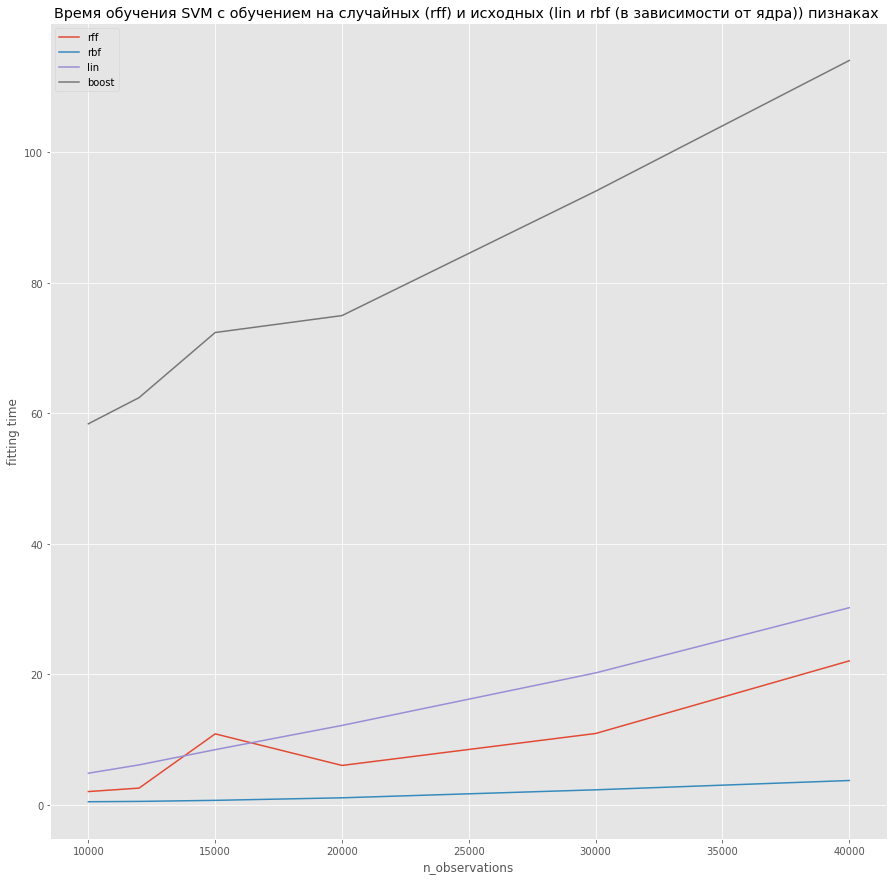

In [104]:
fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=data, y='time_rff_fit', x='n_observations', ax=ax)
sns.lineplot(data=data, y='time_rbf_fit', x='n_observations', ax=ax)
sns.lineplot(data=data, y='time_lin_fit', x='n_observations', ax=ax)
sns.lineplot(data=boost, y='time_boost_fit', x=[10000,12000,15000,20000,30000,40000], ax=ax)
ax.legend(['rff','rbf','lin','boost'])
ax.set_ylabel('fitting time')
ax.set_title('Время обучения SVM с обучением на случайных (rff) и исходных (lin и rbf (в зависимости от ядра)) признаках ');

In [102]:
boost

,time_boost_fit,time_boost_predict,accuracy_boost
0,58.388212,0.092869,0.8634
1,62.399767,0.079222,0.8668
2,72.376939,0.068284,0.8718
3,74.971373,0.058128,0.8764
4,94.033286,0.099484,0.8811
5,114.068163,0.054521,0.8840


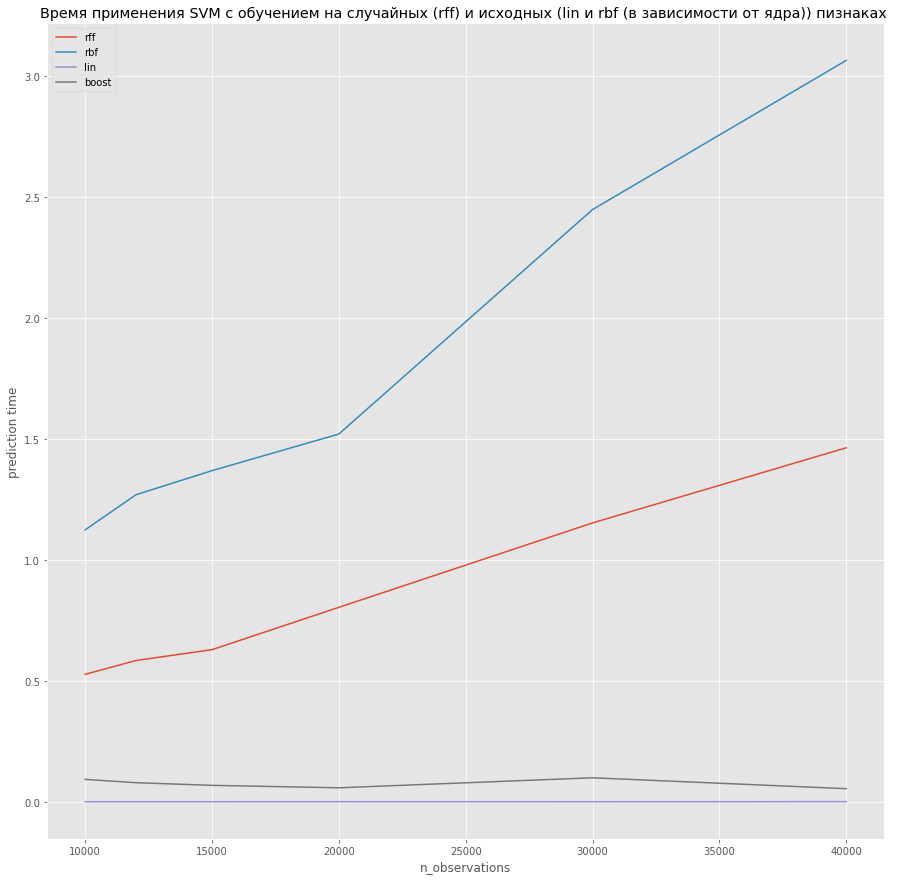

In [106]:
fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=data, y='time_rff_predict', x='n_observations', ax=ax)
sns.lineplot(data=data, y='time_rbf_predict', x='n_observations', ax=ax)
sns.lineplot(data=data, y='time_lin_predict', x='n_observations', ax=ax)
sns.lineplot(data=boost, y='time_boost_predict', x=[10000,12000,15000,20000,30000,40000], ax=ax)
ax.legend(['rff','rbf','lin','boost'])
ax.set_ylabel('prediction time')
ax.set_title('Время применения SVM с обучением на случайных (rff) и исходных (lin и rbf (в зависимости от ядра)) признаках ');

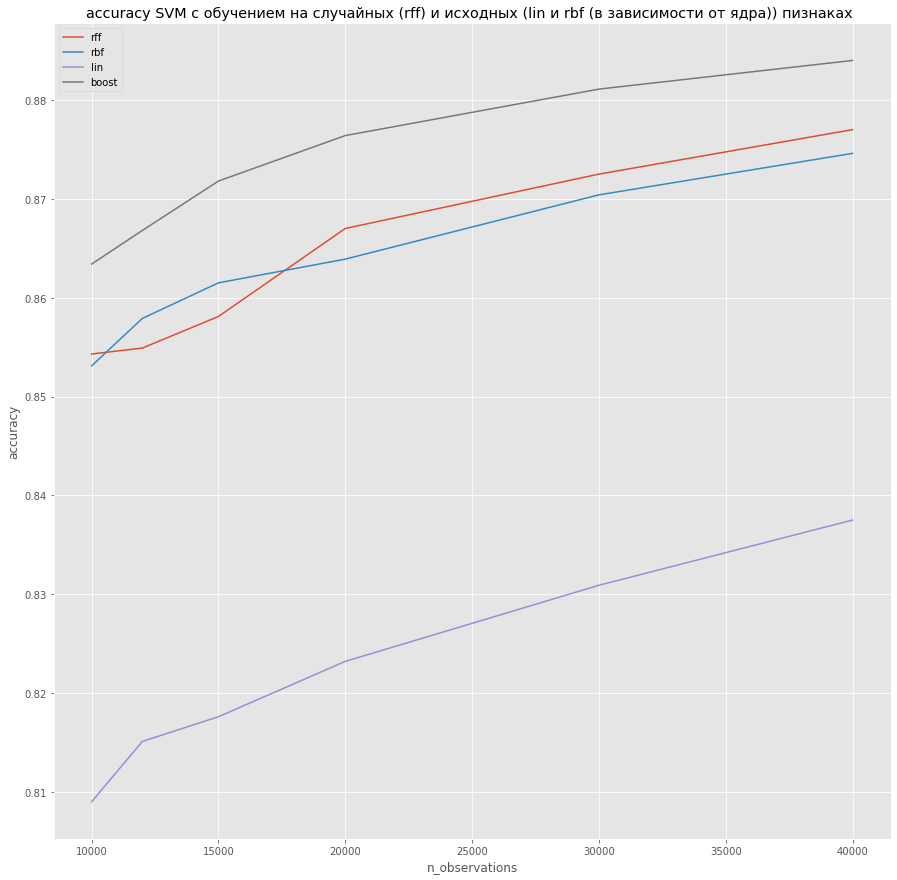

In [107]:
fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=data, y='accuracy_rff', x='n_observations', ax=ax)
sns.lineplot(data=data, y='accuracy_rbf', x='n_observations', ax=ax)
sns.lineplot(data=data, y='accuracy_lin', x='n_observations', ax=ax)
sns.lineplot(data=boost, y='accuracy_boost', x=[10000,12000,15000,20000,30000,40000], ax=ax)
ax.legend(['rff','rbf','lin','boost'])
ax.set_ylabel('accuracy')
ax.set_title('accuracy SVM с обучением на случайных (rff) и исходных (lin и rbf (в зависимости от ядра)) признаках ');

SVM на линейном ядре  дольше всего обучается, выдает наихудшее качество из всех рассмотренных моделей, однако является самым быстрым в применении.
SVM на гауссовом ядре учится быстрее всего, выдает хорошее качество (немного уступает RFF), однако самый долгий в применении(более того, с ростом данных, время его применения сильно растет).
Градиентый бустинг самый долгий в обучении (и это не считая еще и валидации), однако выдает крайне высокое качество по сравнению с другими рассмотренными моделями, и практически также быстр в применении как и SVM на линеном ядре.
RFF на SVM с линейным ядром является по сути компромиссом: выдает высокое качество сравнимое с SVM на rbf, хотя уступает бустингу, учится медленне SVM на rbf, но быстрее других рассмотренных моделей, по времени применения его поведение похоже на rbf (то есть растет, с ростом данных), однако просиходит это намного медленнее (рост времени обучения с увеличением данным)

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [8]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [9]:
%%time
rff_no_pca = RFFPipeline(classifier = 'logreg', use_PCA=False)
rff_no_pca.fit(x_train[0:1000], y_train[0:1000])

MemoryError: Unable to allocate 11.7 GiB for an array with shape (1000000, 2, 784) and data type float64

In [97]:
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1).astype(np.float32)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1).astype(np.float32)
rff_no_pca = RFFPipeline(classifier = 'logreg', use_PCA=False)
rff_no_pca.fit(x_train[0:10000], y_train[0:10000])
accuracy_score(y_test, rff_no_pca.predict(x_test))

0.7985

In [98]:
%%time
rff = RFFPipeline(classifier = 'logreg', use_PCA=True)
rff.fit(x_train[0:10000], y_train[0:10000])

Wall time: 3min 10s


RFFPipeline()

In [99]:
accuracy_score(y_test, rff.predict(x_test))

0.8587

Использование PCA значительно улучает accuracy RFF

In [10]:
accuracy = []
for n in tqdm(range(50,10**4,150)):
    rff = RFFPipeline(classifier = 'svm',n_features = n)
    rff.fit(x_train[0:10000], y_train[0:10000])
    accuracy.append(accuracy_score(y_test, rff.predict(x_test)))

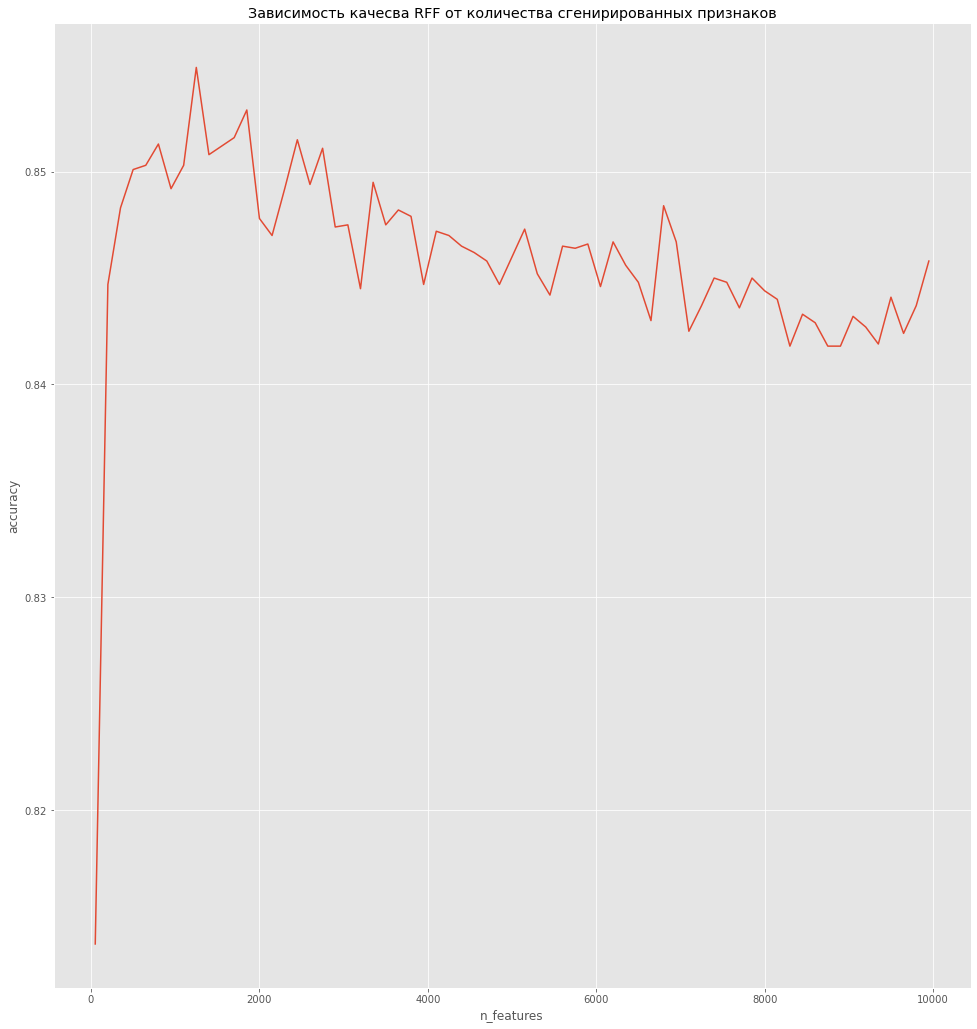

In [11]:
df = pd.DataFrame({'accuracy':accuracy, 'n_features':[n for n in range(50,10**4, 150)]})
sns.relplot(data=df, x = 'n_features', y = 'accuracy', kind = 'line')
ax = plt.gca()
ax.figure.set_size_inches(15,15)
ax.set_title('Зависимость качесва RFF от количества сгенирированных признаков');

Существует оптимальное количество n_features, после которого качество начинает убывать и выходит на плато

In [12]:
time_log_fit = []
time_svm_fit = []
time_log_predict = []
time_svm_predict = []
accuracy_svm = []
accuracy_log = []
observations_2 = []
for i in tqdm(enumerate([10000,12000,15000,20000,30000])):
    start_time = time.time()
    rff = RFFPipeline(classifier = 'svm')
    rff.fit(x_train[0:i[1]], y_train[0:i[1]])
    time_svm_fit.append((time.time() - start_time)/60)
    
    start_time = time.time()
    pred_rff = rff.predict(x_test)
    time_svm_predict.append((time.time() - start_time)/60)
    
    accuracy_svm.append(accuracy_score(y_test, pred_rff))
    
    start_time = time.time()
    rff = RFFPipeline(classifier = 'logreg')
    rff.fit(x_train[0:i[1]], y_train[0:i[1]])
    time_log_fit.append((time.time() - start_time)/60)
    
    start_time = time.time()
    pred_rff = rff.predict(x_test)
    time_log_predict.append((time.time() - start_time)/60)
    
    accuracy_log.append(accuracy_score(y_test, pred_rff))
    
    observations_2.append(i[1])

In [13]:
data = pd.DataFrame({'time_log_fit':time_log_fit,
                     'time_svm_fit': time_svm_fit,
                     'time_log_predict':time_log_predict,
                     'time_svm_predict':time_svm_predict,
                     'accuracy_svm':accuracy_svm,
                     'accuracy_log':accuracy_log,
                     'observations_2':observations_2})


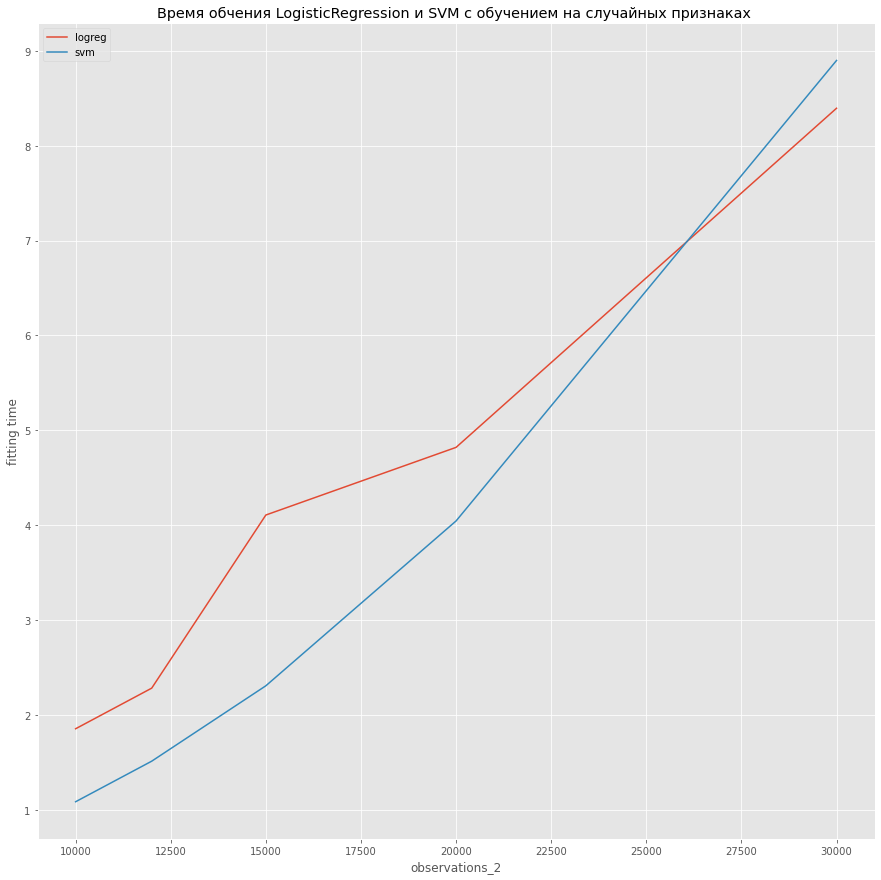

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=data, y='time_log_fit', x='observations_2', ax=ax)
sns.lineplot(data=data, y='time_svm_fit', x='observations_2', ax=ax)
ax.legend(['logreg','svm'])
ax.set_ylabel('fitting time')
ax.set_title('Время обчения LogisticRegression и SVM с обучением на случайных признаках ');

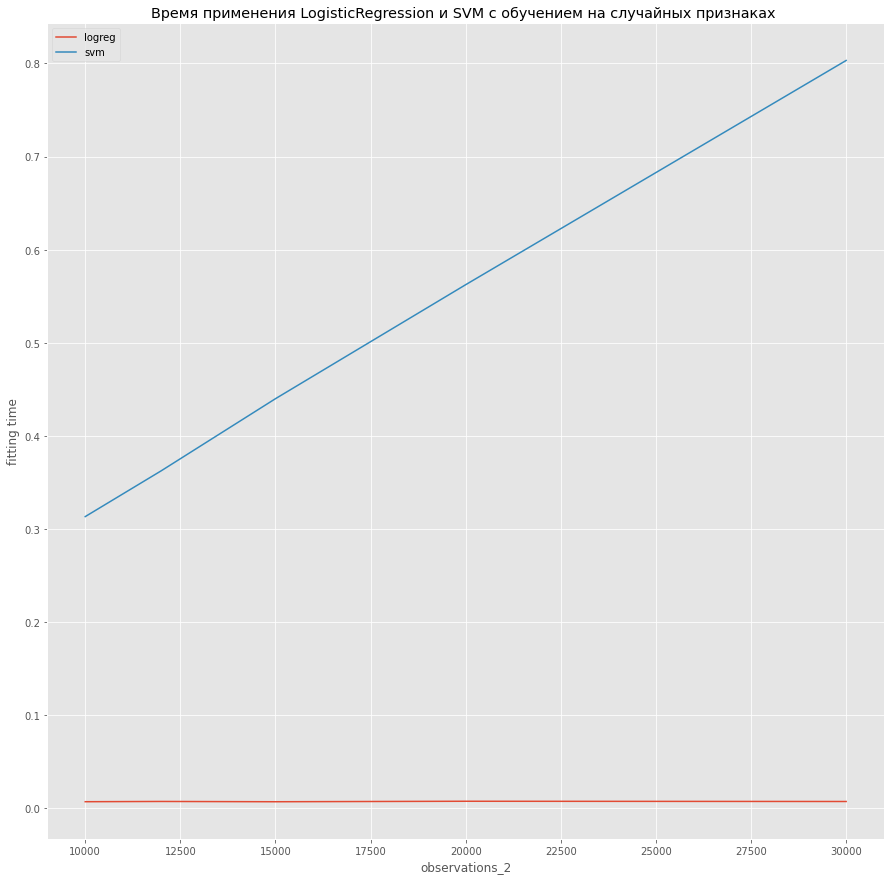

In [15]:
fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=data, y='time_log_predict', x='observations_2', ax=ax)
sns.lineplot(data=data, y='time_svm_predict', x='observations_2', ax=ax)
ax.legend(['logreg','svm'])
ax.set_ylabel('fitting time')
ax.set_title('Время применения LogisticRegression и SVM с обучением на случайных признаках ');

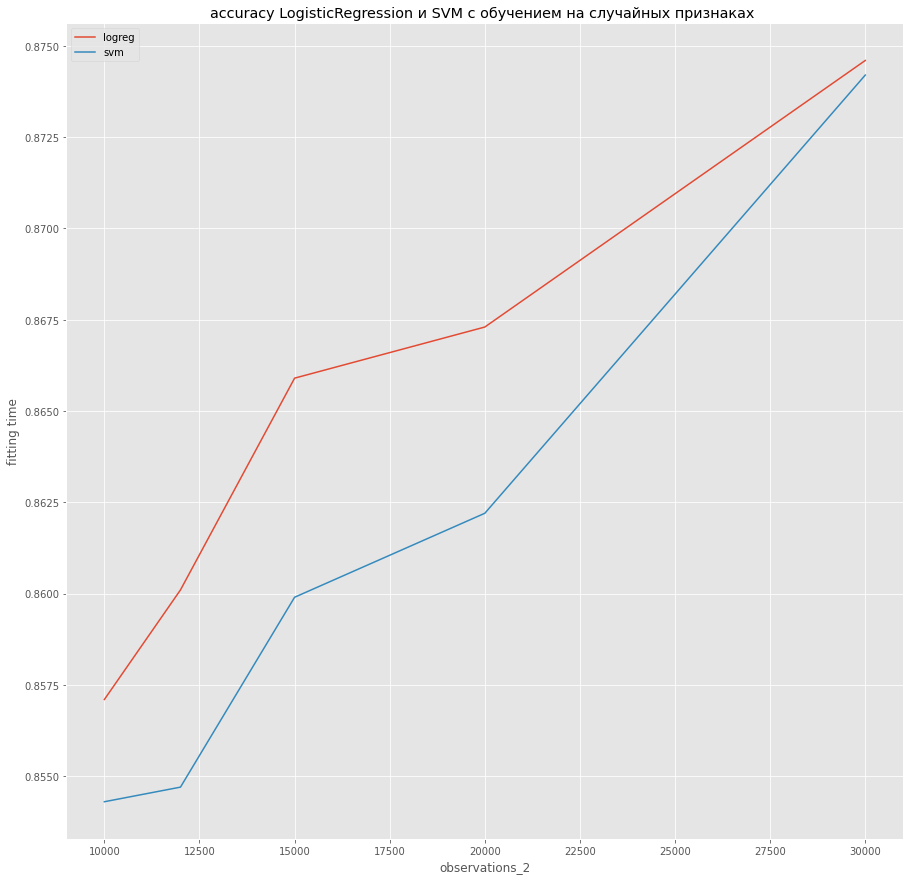

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=data, y='accuracy_log', x='observations_2', ax=ax)
sns.lineplot(data=data, y='accuracy_svm', x='observations_2', ax=ax)
ax.legend(['logreg','svm'])
ax.set_ylabel('fitting time')
ax.set_title('accuracy LogisticRegression и SVM с обучением на случайных признаках ');

Судя по графикам  RFF c логистической регрессией быстрее обучается на больших данных, гораздо быстрее применяется, выдает чуть лучшее accuracy на приведенном количесве данных, однако с ростом данных у RFF c SVM ассuracy растет быстрее

In [17]:
data

,time_log_fit,time_svm_fit,time_log_predict,time_svm_predict,accuracy_svm,accuracy_log,observations_2
0,1.853359,1.083863,0.007054,0.313294,0.8543,0.8571,10000
1,2.281499,1.511452,0.007333,0.362546,0.8547,0.8601,12000
2,4.106816,2.306408,0.007030,0.439922,0.8599,0.8659,15000
3,4.820090,4.044272,0.007550,0.562365,0.8622,0.8673,20000
4,8.395479,8.899255,0.007290,0.803194,0.8742,0.8746,30000


In [18]:
data.to_csv('Sereja.csv')

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [156]:
from math import ceil

In [199]:
from sklearn.base import BaseEstimator, TransformerMixin


class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:    
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = len(X.T)
        rand = np.random.randint(low=0, high = len(X), size = 2*10**6).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X[rand][:,0] - X[rand][:,1])**2,axis = 1)))
        if self.n_features > self.new_dim:
            for  i in range(ceil(self.n_features/self.new_dim)):
                G = np.random.normal(0, 1, size=(self.new_dim,self.new_dim))
                Q = np.linalg.qr(G, 'complete')[0]
                S = np.sqrt(np.diag(np.random.chisquare(self.new_dim,size=self.new_dim)))
                if i == 0:   
                    self.W = 1/sigma * (S @ Q)
                    w = self.W
                else:
                    self.W = np.vstack((w,1/sigma * (S @ Q)))
                    w = self.W
                self.W = w[:self.n_features,:]
        else:
            G = np.random.normal(0, 1, size=(self.new_dim,self.new_dim))
            Q = np.linalg.qr(G, 'complete')[0]
            S = np.sqrt(np.diag(np.random.chisquare(self.new_dim,size=self.new_dim)))
            self.W = (1/sigma * (S @ Q))[:self.n_features]
        # return self.W
        self.b = np.random.uniform(-np.pi, np.pi, size = (1,self.n_features))
        x_res = np.cos(np.dot(X,(self.W).T ) + self.b)
        if self.classifier == 'logreg':
            self.cl = LogisticRegression(max_iter = 10**4)
            self.cl.fit(x_res, y)
        else:
            self.cl = SVC(kernel = 'linear', probability=True)
            self.cl.fit(x_res,y)
        #raise NotImplementedError
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = np.cos(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict_proba(X_test)
    
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = np.cos(np.dot(X, (self.W).T) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict(X_test)

In [206]:
%%time
orf = ORFPipeline(n_features=1001,  classifier = 'logreg', new_dim=49)
orf.fit(x_train[:1000], y_train[:1000])

Wall time: 7.43 s


In [207]:
print(accuracy_score(y_test,orf.predict(x_test)))

0.8006


In [208]:
%%time
orf = ORFPipeline(n_features=101,  classifier = 'logreg', new_dim=105)
orf.fit(x_train[:1000], y_train[:1000])
print(accuracy_score(y_test,orf.predict(x_test)))

0.7888
Wall time: 16.4 s


In [159]:
%%time
rrf = RFFPipeline(n_features=1000,classifier = 'logreg' )
rrf.fit(x_train[:1000], y_train[:1000])
print(accuracy_score(y_test,rrf.predict(x_test)))

0.7946
Wall time: 10 s


ORF быстре обучается и выдет лучше accuracy

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [306]:
%%time
rrf = RFFPipeline(n_features=1000,classifier = 'logreg' )
rrf.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,rrf.predict(x_test)))

0.8446
Wall time: 46.9 s


In [295]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪from sklearn.base import BaseEstimator, TransformerMixin


class MYPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', func=np.cos):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.func = func
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:    
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = len(X.T)
        rand = np.random.randint(low=0, high = len(X), size = 2*10**6).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X[rand][:,0] - X[rand][:,1])**2,axis = 1)))
        self.W  = np.random.normal(0, 1/sigma, size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size = (1,self.n_features))
        x_res = self.func(np.dot(X, self.W) + self.b)
        if self.classifier == 'logreg':
            self.cl = LogisticRegression(max_iter = 10**4)
            self.cl.fit(x_res, y)
        else:
            self.cl = SVC(kernel = 'linear', probability=True)
            self.cl.fit(x_res,y)
        #raise NotImplementedError
        #return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict_proba(X_test)
    
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict(X_test)

In [296]:
my = MYPipeline(n_features=1000,classifier = 'logreg', func = np.exp )
my.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,my.predict(x_test)))

0.8037


In [297]:
my = MYPipeline(n_features=1000,classifier = 'logreg', func = np.sign)
my.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,my.predict(x_test)))

0.7769


In [298]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
my = MYPipeline(n_features=1000,classifier = 'logreg', func = sigmoid)
my.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,my.predict(x_test)))

0.8247


In [299]:
import scipy
my = MYPipeline(n_features=1000,classifier = 'logreg', func = scipy.special.gamma)
my.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,my.predict(x_test)))

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4027


Попробуем другие распределения

1) Меняем распределение b

In [300]:
class MYPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', func=np.cos):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.func = func
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:    
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = len(X.T)
        rand = np.random.randint(low=0, high = len(X), size = 2*10**6).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X[rand][:,0] - X[rand][:,1])**2,axis = 1)))
        self.W  = np.random.normal(0, 1/sigma, size=(self.new_dim, self.n_features))
        self.b = np.random.normal(0, 2*np.pi, size = (1,self.n_features))
        x_res = self.func(np.dot(X, self.W) + self.b)
        if self.classifier == 'logreg':
            self.cl = LogisticRegression(max_iter = 10**4)
            self.cl.fit(x_res, y)
        else:
            self.cl = SVC(kernel = 'linear', probability=True)
            self.cl.fit(x_res,y)
        #raise NotImplementedError
        #return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict_proba(X_test)
    
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict(X_test)

In [301]:
my = MYPipeline(n_features=1000,classifier = 'logreg')
my.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,my.predict(x_test)))

0.8444


2) Изменим распределение W

In [312]:
# t распределение с new_dim степенями свободы
class MYPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', func=np.cos):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.func = func
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:    
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = len(X.T)
        rand = np.random.randint(low=0, high = len(X), size = 2*10**6).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X[rand][:,0] - X[rand][:,1])**2,axis = 1)))
        self.W  =1/sigma* np.random.standard_t(self.new_dim, size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size = (1,self.n_features))
        x_res = self.func(np.dot(X, self.W) + self.b)
        if self.classifier == 'logreg':
            self.cl = LogisticRegression(max_iter = 10**4)
            self.cl.fit(x_res, y)
        else:
            self.cl = SVC(kernel = 'linear', probability=True)
            self.cl.fit(x_res,y)
        #raise NotImplementedError
        #return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict_proba(X_test)
    
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict(X_test)

In [313]:
my = MYPipeline(n_features=1000,classifier = 'logreg')
my.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,my.predict(x_test)))

0.8414


In [314]:
# Распределение Лапласа
class MYPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', func=np.cos):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.func = func
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:    
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = len(X.T)
        rand = np.random.randint(low=0, high = len(X), size = 2*10**6).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X[rand][:,0] - X[rand][:,1])**2,axis = 1)))
        self.W  = 1/sigma * np.random.laplace( size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size = (1,self.n_features))
        x_res = self.func(np.dot(X, self.W) + self.b)
        if self.classifier == 'logreg':
            self.cl = LogisticRegression(max_iter = 10**4)
            self.cl.fit(x_res, y)
        else:
            self.cl = SVC(kernel = 'linear', probability=True)
            self.cl.fit(x_res,y)
        #raise NotImplementedError
        #return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict_proba(X_test)
    
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict(X_test)

In [315]:
my = MYPipeline(n_features=1000,classifier = 'logreg')
my.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,my.predict(x_test)))

0.8368


In [307]:
from sklearn.ensemble import RandomForestClassifier

In [317]:
class MYPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', func=np.cos):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.func = func
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:    
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = len(X.T)
        rand = np.random.randint(low=0, high = len(X), size = 2*10**6).reshape(-1,2)
        sigma = np.sqrt(np.median(np.sum((X[rand][:,0] - X[rand][:,1])**2,axis = 1)))
        self.W  = 1/sigma * np.random.normal(0,1, size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size = (1,self.n_features))
        x_res = self.func(np.dot(X, self.W) + self.b)
        if self.classifier == 'logreg':
            self.cl = LogisticRegression(max_iter = 10**4)
            self.cl.fit(x_res, y)
        elif self.classifier == 'svm':
            self.cl = SVC(kernel = 'linear', probability=True)
            self.cl.fit(x_res,y)
        elif self.classifier == 'tree':
            self.cl = RandomForestClassifier(n_estimators = 500, max_depth = 20,min_samples_leaf=5)
            self.cl.fit(x_res, y)
        #raise NotImplementedError
        #return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict_proba(X_test)
    
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X_test = self.func(np.dot(X, self.W) + self.b)
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        #raise NotImplementedError
        return self.cl.predict(X_test)

In [318]:
my = MYPipeline(n_features=1000,classifier = 'tree')
my.fit(x_train[:5000], y_train[:5000])
print(accuracy_score(y_test,my.predict(x_test)))

0.8151


Все попытки обойти RFF на Логреге с помощью изменний функций и способов генерации фичей не удались